In [1]:
import numpy as np
import random

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from tqdm import tqdm
from tqdm import trange
import time

import os
import math
from math import sin
from icecream import ic
import json
import argparse

# checklist 1: uncomment matplotlib.use('Agg')
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.gridspec as gridspec
# plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline  

# plt.style.use('dark_background')

from scipy.io import loadmat
import scipy
from scipy import signal
from scipy.fftpack import fft, ifft
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

i_seed = 0

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import PIL

import sys

sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

from plotting_tools import *
from preprocessing import *
from setting import *
from surrogate_extraction import *
from dataIO import *
from filters import *
from spectral_module import *
from stage4_regression import *
# from unet_extension.dataset_util import *
# from unet_extension.evaluation_util import *
# from unet_extension.models import *
# from unet_extension.training_util import *


import datetime
import time

# checklist 2: comment out all magic command
from importlib import reload
%load_ext autoreload
%autoreload 2


/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (2.1.1) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# Fs = FS_RESAMPLE

# label_names = ['br', 'heart_rate_cosmed', 'rer', 'vco2_ml_min', 've', 'vo2_ml_min', 'vt']
# sig_names = ['ECG', 'accelX', 'accelY', 'accelZ']

In [3]:
parser = argparse.ArgumentParser(description='RR_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
# args = parser.parse_args(['--input_folder', '../../../covid/results/stage3/win60_overlap95_seq20_ECG_AMpt_norm_script1/', 
# args = parser.parse_args(['--input_folder', '../../data/stage4_UNet/', 
args = parser.parse_args(['--input_folder', '../../data/stage4_UNet/', 
                          '--output_folder', '../../data/stage5_UNet/'])
                          
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage4_UNet/', output_folder='../../data/stage5_UNet/', training_params_file='training_params_list.json')


In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
# outputdir = outputdir+inputdir.split('/')[-2]+'/'

# training_params_file = args.training_params_file

In [5]:
steps_thre = 50
# list_modalitites = ['PPG-select', 'ppg-g-1', 'ppg-g-2', 'ppg-ir-1', 'ppg-ir-2', 'SCG-select', 'SCG', 'SCGx-AMpt', 'SCGy-AMpt', 'SCGxyz-AMpt']
# list_modalitites = ['test']
# list_modalitites = ['PPG']
list_modalitites = ['ECG-SR+PPG']

list_method = ['U-Net']

list_TF_types = ['target']

domain_name = 'CDC_dataset'

# act_type = 'run'
# act_type = 'rest'
act_type = '6MWT'

if act_type=='rest':
    task_ids = [0]
#     reject_act = [1, 2, 3, 4, 5, 6] # keep 0
#     reject_act = [1, 2, 3, 4, 5, 6, 10] # keep 0
elif act_type=='6MWT':
    task_ids = [6]
#     reject_act = [0 ,1, 2, 3, 4, 5] # keep 6
    reject_act = [0 ,1, 2, 3, 4, 5, 10] # keep 6
elif act_type=='ER':
    task_ids = [1,2,3,4,5]
#     reject_act = [0, 6, 10] # keep 1, 2, 3, 4
elif act_type=='run':
    task_ids = [10]
    reject_act = [0 ,1, 2, 3, 4, 5, 6] # keep 1, 2, 3, 4


In [6]:
act_type

'6MWT'

In [7]:
# variant = 'baseline'
# list_variants = ['baseline', 'SE_block']
list_variants = ['baseline']
# list_variants = ['AT_block']
# list_variants = ['baseline' 'AT_block' 'Late_UNet' 'Attention_UNet']
# list_variants = ['baseline', 'Late_UNet', 'Attention_UNet']

# list_variants = ['baseline', 'AT_block']

# variant = 'SE_block'

In [8]:
if domain_name=='GT_dataset':

    home = expanduser("~")

    filename_subinfo = home+'/'+ 'Estimation_RR/covid/Mobashir_CosmedWearable/Cosmed Wearable Subject Information.xlsx'
    df_subinfo = pd.read_excel(filename_subinfo) 
    df_subinfo

    df_subinfo = df_subinfo.rename(columns={'Height in cm': 'Height', 'Weight in Kg': 'Weight', 'Subject ID':'Subject_ID'})

    df_subinfo['Subject_ID'] = df_subinfo['Subject_ID'].apply(lambda x: int(x.split('M')[0].split('F')[0].split('CW')[1]))
    df_subinfo = df_subinfo[['Subject_ID', 'Age', 'Height', 'Weight', 'Gender']].drop_duplicates().reset_index(drop=True)
    df_subinfo['BMI'] = df_subinfo['Weight'].values / (df_subinfo['Height'].values/100)**2
    df_subinfo['Fitzpatrick'] = -1
    
elif domain_name=='CDC_dataset':

    filename_subinfo = '../../data/raw/FS Subject Information.xlsx'
    df_subinfo = pd.read_excel(filename_subinfo, sheet_name='Subject info') 

    i_sub_last = np.where(df_subinfo['Subject_ID'].isnull()==True)[0][0]
    df_subinfo = df_subinfo[:i_sub_last]

#     sys.exit()
    df_subinfo = df_subinfo[['Subject_ID', 'Age', 'Height(cm)', 'Weight(Kg)', 'Gender(0=Male,1=Female)', 'Fitzpatrick', '6MWT distance (m)', '6MWT-R distance (m)', '(corrected) 6MWT distance (m)', '(corrected) 6MWT-R distance (m)', 'Fitzpatrick']]
    df_subinfo = df_subinfo.rename(columns={'Height(cm)': 'Height', 'Weight(Kg)': 'Weight', 'Gender(0=Male,1=Female)': 'Gender'})
    df_subinfo['BMI'] = df_subinfo['Weight'].values / (df_subinfo['Height'].values/100)**2
    df_subinfo['Subject_ID'] = df_subinfo['Subject_ID'].astype(int)
    

In [9]:
inputdir

'../../data/stage4_UNet/'

# get val data

In [10]:
df_outputlabel_ALL = pd.DataFrame()
   
for modality in list_modalitites:
        
    for TF_type in list_TF_types:
        
        for variant in list_variants:

    #         csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_RR_cosmed.csv'
            csv_dir = inputdir + domain_name + '/' +  modality + '/{}/{}/numeric_results/df_outputlabel_val_RR_cosmed.csv'.format(variant, TF_type)

            try:
                df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
            except:
                print(modality, 'directory does not exist')
                continue
    #         df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
            df_outputlabel_val_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_RR_cosmed['label_est'] - df_outputlabel_val_RR_cosmed['label'])

    #         csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'
            csv_dir = inputdir + domain_name + '/' + modality + '/{}/{}/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'.format(variant, TF_type)

            try:
                df_outputlabel_val_input_RR_cosmed = pd.read_csv(csv_dir)  
            except:
                print(modalitity, 'directory does not exist')
                continue

            df_outputlabel_val_input_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_input_RR_cosmed['label_est'] - df_outputlabel_val_input_RR_cosmed['label'])

            df_outputlabel_val_input_RR_cosmed['modality'] = modality
            df_outputlabel_val_input_RR_cosmed['est_method'] = 'ST'
            df_outputlabel_val_input_RR_cosmed['TF_type'] = TF_type


            df_outputlabel_val_RR_cosmed['modality'] = modality
            

#             if variant=='SE_block':
            if 'block' in variant:
                df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net-' + variant
            else:
                df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net'
#             df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net'
            df_outputlabel_val_RR_cosmed['TF_type'] = TF_type

            df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_input_RR_cosmed)
            df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_RR_cosmed)
            
            print('data for **{} {} {}** loaded'.format(modality, TF_type, variant))


data for **ECG-SR+PPG target baseline** loaded


In [11]:
# csv_dir

In [12]:
list_CV = df_outputlabel_ALL['CV'].unique()

df_subinfo_4paper = pd.DataFrame()

for Subject_ID in df_subinfo['Subject_ID'].unique():
    if Subject_ID in list_CV:
        df_subinfo_4paper = df_subinfo_4paper.append(df_subinfo[df_subinfo['Subject_ID']==Subject_ID])

df_subinfo_4paper = df_subinfo_4paper.reset_index(drop=True)

In [13]:
# df_subinfo_4paper.describe()
(df_subinfo_4paper['Gender']==1).sum()
# df_subinfo
# df_subinfo[df_subinfo['Subject_ID']==Subject_ID]

10

In [14]:
(df_subinfo_4paper['Gender']==2).sum()


7

In [15]:
df_outputlabel_ALL['activity'].unique()

array([ 0.,  2.,  1.,  3.,  4.,  5.,  6., 10.])

In [16]:
df_outputlabel_ALL['CV'].unique()

array([104., 105., 106., 107., 108., 110., 111., 113., 114., 115., 116.,
       117., 118., 119., 120., 121., 212.])

# select only the activities I am interested in

In [17]:
mask_task = np.in1d(df_outputlabel_ALL['activity'].values, np.asarray(task_ids))
df_outputlabel_ALL = df_outputlabel_ALL[mask_task]
df_outputlabel_ALL['activity'].unique()

array([6.])

In [18]:
# mask_set = ~np.isin(df_outputlabel_ALL['activity'].values, reject_act)
# df_outputlabel_ALL = df_outputlabel_ALL[mask_set]
# df_outputlabel_ALL['activity'].unique()

In [19]:
def get_best_estimates(matrix_modality):

    df_matrix = []
    for i, key in enumerate(matrix_modality):
        df_matrix.append(matrix_modality[key].values)

    df_matrix = np.stack(df_matrix).transpose(1,0,2) # number of samples x number of modalities x number of columns
#     print(df_matrix.shape)

    i_RQI = list(df_outputlabel.columns).index('RQI_kurtosis')
#     i_RQI = list(df_outputlabel.columns).index('RQI_fft')
    i_best_modalities = np.argmax(df_matrix[:,:,i_RQI], axis=1)
#     print(i_best_modalities)
    df_matrix = df_matrix[np.arange(i_best_modalities.shape[0]), i_best_modalities, :]

    df_matrix = pd.DataFrame(df_matrix, columns=list(df_outputlabel.columns))
#     print(df_matrix)
#     df_matrix['RQI_fft'] = -1
#     df_matrix['RQI_ideal'] = -np.abs(df_matrix['label_est'] - df_matrix['label'])
#     df_matrix['modality'] = 'select_' + df_matrix['modality'].astype(str)
    df_matrix['modality'] = 'selected'
#     print(df_matrix)

    return df_matrix

# add an additional moadility: ``selected``
# this may be better than using all (not true)

In [20]:
df_outputlabel_ALL['est_method'].unique()

array(['ST', 'U-Net'], dtype=object)

In [21]:

if 'U-Net-AT_block' not in df_outputlabel_ALL['est_method'].unique():
    
    if 'U-Net-SE_block' not in df_outputlabel_ALL['est_method'].unique():

        df_outputlabel_selected = []

        matrix_modality = {}
        for modality in df_outputlabel_ALL['modality'].unique():
        #     for modality in ['ECG', 'PPG', 'SCG']:
        #         for TF_type in df_outputlabel_ALL_train['TF_type'].unique():
        #     df_outputlabel = df_outputlabel_ALL[(df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)]
            df_outputlabel = df_outputlabel_ALL[(df_outputlabel_ALL['modality']==modality)]
        #     print(df_outputlabel.shape)
            matrix_modality[modality] = df_outputlabel
        df_matrix = get_best_estimates(matrix_modality)
        # sys.exit()
        df_outputlabel_selected.append(df_matrix)
        df_outputlabel_selected = pd.concat(df_outputlabel_selected)


In [22]:
include_selected = False
if include_selected:
    df_outputlabel_ALL_selected = pd.concat([df_outputlabel_ALL, df_outputlabel_selected])
    print(df_outputlabel_selected.shape, df_outputlabel_ALL.shape, df_outputlabel_ALL_selected.shape)
else:
    df_outputlabel_ALL_selected = df_outputlabel_ALL
    print(df_outputlabel_ALL.shape, df_outputlabel_ALL_selected.shape)



(2778, 14) (2778, 14)


In [23]:
df_outputlabel_ALL_selected['CV'].unique().shape

(17,)

In [24]:
df_outputlabel_ALL_selected['est_method'].unique()

array(['ST', 'U-Net'], dtype=object)

In [25]:
# aggregate estimated to get performance for each modality, TF_type, est_method, subject_id

In [26]:
def get_df_performance_agg(df_outputlabel_ALL):
    # agg information across modality (ECG, SCG, ...), TF_type (pretrain, source, target), subject_id
    
    df_performance_agg = pd.DataFrame()

    for modality in df_outputlabel_ALL['modality'].unique():
        for TF_type in df_outputlabel_ALL['TF_type'].unique():

            for est_method in list_method:
                
#                 for task_id in df_outputlabel_ALL['activity'].unique():
        
                task_id = 0
        
                for subject_id in df_outputlabel_ALL['CV'].unique():

                    # this condition is for est_method=ST or est_method=U-Net
                    if 'RQI' not in est_method:
#                         mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['activity']==task_id) & (df_outputlabel_ALL['CV']==subject_id)
                        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
                        if mask_df.sum()==0:
#                                 print('mask_df is empty')
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)
                            continue
                        df_outputlabel = df_outputlabel_ALL[mask_df]
            #             MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
                        coverage = 100


                    # consider RQI, reject samples accordingly
                    else:
#                         mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method.split(' ')[0]) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['activity']==task_id) & (df_outputlabel_ALL['CV']==subject_id)
                        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method.split(' ')[0]) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
                        if mask_df.sum()==0:
#                                 print('mask_df is empty')
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)
                            continue
                        df_outputlabel = df_outputlabel_ALL[mask_df]
        #                 sys.exit()

                        mask_RQI = (df_RQI_threshold['modality']==modality) & (df_RQI_threshold['TF_type']==TF_type)

                        # df_RQI_threshold may not contain modality ``selected``, skip it
                        if mask_RQI.sum()==0:
                            continue
                        df_outputlabel= df_outputlabel.merge(df_RQI_threshold[mask_RQI], on=['CV'])
        #                 df_outputlabel= df_outputlabel.merge(df_RQI_threshold, on=['CV'])


                        RQI_name = est_method.split(' ')[1]
                        RQI_mask = df_outputlabel[RQI_name] > df_outputlabel[RQI_name+'_threshold']
        #                 sys.exit()
                        df_outputlabel = df_outputlabel[RQI_mask]
                        coverage = RQI_mask.mean()*100

#                             if coverage==0:
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)

                    if coverage==0:
                        
                        print('{}: coverage=0'.format(subject_id))
                        continue


#                         if df_outputlabel.shape[0]==0:
#                             print( mask_df.sum() )
#                             print(modality, TF_type, est_method, task_id, subject_id, coverage)
#                             print(RQI_mask.sum())
#                             print(df_outputlabel)
#                             print( get_RMSE(df_outputlabel['label'], df_outputlabel['label_est']))


                    MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
#                     PCC = get_PCC(df_outputlabel['label'], df_outputlabel['label_est'])
#                     CoeffDeterm = get_CoeffDeterm(df_outputlabel['label'], df_outputlabel['label_est'])
                    MAPE, _ = get_MAPE(df_outputlabel['label'], df_outputlabel['label_est'])
                    RMSE = get_RMSE(df_outputlabel['label'], df_outputlabel['label_est'])

                    one_dict = {
                        'MAE_mean': MAE_mean,
                        'MAE_std': MAE_std,
#                         'PCC': PCC,
#                         'CoeffDeterm': CoeffDeterm,
                        'MAPE': MAPE*100,
                        'RMSE': RMSE,
                        'method': est_method,
                        'modality': modality,
                        'TF_type': TF_type,
                        'coverage': coverage,
                        'task': tasks_dict_reversed[task_id],
                        'subject_id': subject_id
                    }

                    df_performance_agg = df_performance_agg.append(one_dict, ignore_index=True)

    return df_performance_agg

In [27]:
df_performance_agg_joint = get_df_performance_agg(df_outputlabel_ALL_selected)

In [114]:
# modality = 'ECG'
# est_method = 'U-Net'
# TF_type = 'target'
# # task_id = 0
# subject_id = 106

# mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
# plt.scatter(df_outputlabel_ALL[mask_df]['label'].values, df_outputlabel_ALL[mask_df]['label_est'].values)

In [115]:
# df_outputlabel_ALL['CV'].unique()


In [116]:
# df_performance_agg_joint['method'].unique()

In [28]:
hue_color_dict = {
    'ST': '#F5F4E0',
    'ST RQI_fft': '#928462',

    'source': '#D8D7C5',
    'target': '#B8B7A9',

    
    
    'U-Net': '#B8B7A9',
    'U-Net RQI_fft': '#6A7E7B',
    
    'U-Net source': '#D8D7C5',
    'U-Net target': '#B8B7A9',
    


    'U-Net-AT_block':'#F696A6' ,
    'U-Net-AT_block RQI_fft':'#C4580C' ,
    
    'U-Net-AT_block source': '#E2C3BC',
    'U-Net-AT_block target': '#F696A6',

#     'source': '#F5F4E0',
#     'target': '#D8D7C5',
#     'pretrain': '#B8B7A9',
}


In [29]:
def plot_hue_compare(df, plt_scale=1.5,  x_name='modality', y_name='MAE_mean', hue_name='hue_name', metric_name='MAE_mean', ylims=None, order_list=None, hue_order=None, fig_name=None, show_plot=False, outputdir=None, log_wandb=False, verbose=False):
#     metric_name = 'MAE_mean'
    
    if hue_order is None:
         hue_order=list(hue_color_dict.keys())

    fig, ax = plt.subplots(1,1, figsize=(5*plt_scale,5),dpi=250)
    fontsize=7
    
#     sns.violinplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, palette=TF_color_dict)
    sns.boxplot(x=x_name, y=y_name, hue=hue_name, data=df, ax=ax, palette=hue_color_dict, hue_order=hue_order,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"},
             order = order_list
               )
    ax.tick_params(labelsize=fontsize)


#     sns.swarmplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, color='black', hue_order=list(TF_color_dict.keys()), dodge=True, size=3, alpha=0.8)

    # get the lowest MAE
#     MAE_lowest = []
    df_MAEs = []
    for hue_name in df['hue_name'].unique():
        for modality in df['modality'].unique():
            mean_MAE = df[(df['modality']==modality) & (df['hue_name']==hue_name)][metric_name].mean() 
            if math.isnan(mean_MAE):
                continue
            mae_dict ={
                'hue_name': hue_name,
                'modality': modality,
                'mean_MAE': mean_MAE,
            }
            
            df_MAEs.append( mae_dict )
            
    df_MAEs = pd.DataFrame(df_MAEs)
#     print(df_MAEs)
#     print(df[['mean_MAE']].idxmin())
#     sys.exit()
    i_min = df_MAEs[['mean_MAE']].idxmin().values[0]

    hue_name, modality, MAE_lowest =  df_MAEs.iloc[i_min,:].values
#     hue_name, modality, MAE_lowest
    
#     MAE_lowest = min(MAE_lowest)
    
    
    
    # xmin and xmax 
    xmin = -.8
    xmax = df['modality'].unique().shape[0]-1+0.8
    ax.hlines(y=MAE_lowest, xmin=xmin, xmax=xmax, linewidth=3, color='#627565', alpha=0.5)

    ax.annotate('{:.2f}\n{}\n{}'.format(MAE_lowest, hue_name, modality), xy=(1,MAE_lowest), xytext=(6,0), color='black', 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=8, va="center")
    
    ax.set_xlim(xmin,xmax)

    ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.yaxis.grid(True, which='minor', color='gray', alpha=0.2)
    ax.minorticks_on()
    
#     ax.legend(frameon=True, bbox_to_anchor=(1.05,1))
#     ax.legend(frameon=True, loc='upper right',  bbox_to_anchor=(2,1), fontsize=fontsize)
    ax.get_legend().remove()

    
    if ylims is not None:
        ax.set_ylim(ylims)

#     ax.set_ylim(0,MAE_lowest*5)
    ax_no_top_right(ax)
   
    
    fig.tight_layout()
    print('fig_name is', fig_name)
    
    if fig_name is None:
        fig_name = 'hueXmod'

    if log_wandb:
        wandb.log({fig_name: wandb.Image(fig)})

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)

        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')

    plt.show()
    
    

In [30]:
# metric_name = 'MAE_mean'

# df_MAEs = []
# for hue_name in df['hue_name'].unique():
#     for modality in df['modality'].unique():
#         mean_MAE = df[(df['modality']==modality) & (df['hue_name']==hue_name)][metric_name].mean() 
#         if math.isnan(mean_MAE):
#             continue
#         mae_dict ={
#             'hue_name': hue_name,
#             'modality': modality,
#             'mean_MAE': mean_MAE,
#         }

#         df_MAEs.append( mae_dict )

# df_MAEs = pd.DataFrame(df_MAEs)
# df_MAEs

In [31]:
# method_name = 'U-Net'

# check method_name2 = 'U-Net-AT_block' only

In [32]:
df_performance_agg_joint


,MAE_mean,MAE_std,MAPE,RMSE,method,modality,TF_type,coverage,task,subject_id
0,1.432099,1.439950,4.578546,2.024541,U-Net,ECG-SR+PPG,target,100.0,Baseline,104.0
1,0.975309,1.106518,5.171595,1.469862,U-Net,ECG-SR+PPG,target,100.0,Baseline,105.0
2,1.085366,0.891679,2.954352,1.401219,U-Net,ECG-SR+PPG,target,100.0,Baseline,106.0
3,0.963415,1.621195,3.030157,1.877336,U-Net,ECG-SR+PPG,target,100.0,Baseline,107.0
4,1.626506,1.687189,7.317701,2.336200,U-Net,ECG-SR+PPG,target,100.0,Baseline,108.0
5,6.195122,5.157852,19.836802,8.041053,U-Net,ECG-SR+PPG,target,100.0,Baseline,110.0
6,3.353659,4.098696,10.551597,5.276501,U-Net,ECG-SR+PPG,target,100.0,Baseline,111.0
7,1.621951,1.348435,8.727895,2.104003,U-Net,ECG-SR+PPG,target,100.0,Baseline,113.0
8,1.353659,2.196360,4.321339,2.568572,U-Net,ECG-SR+PPG,target,100.0,Baseline,114.0
9,5.195122,4.972614,16.539317,7.170400,U-Net,ECG-SR+PPG,target,100.0,Baseline,115.0


fig_name is Fig10Xmod_6MWT_modalities


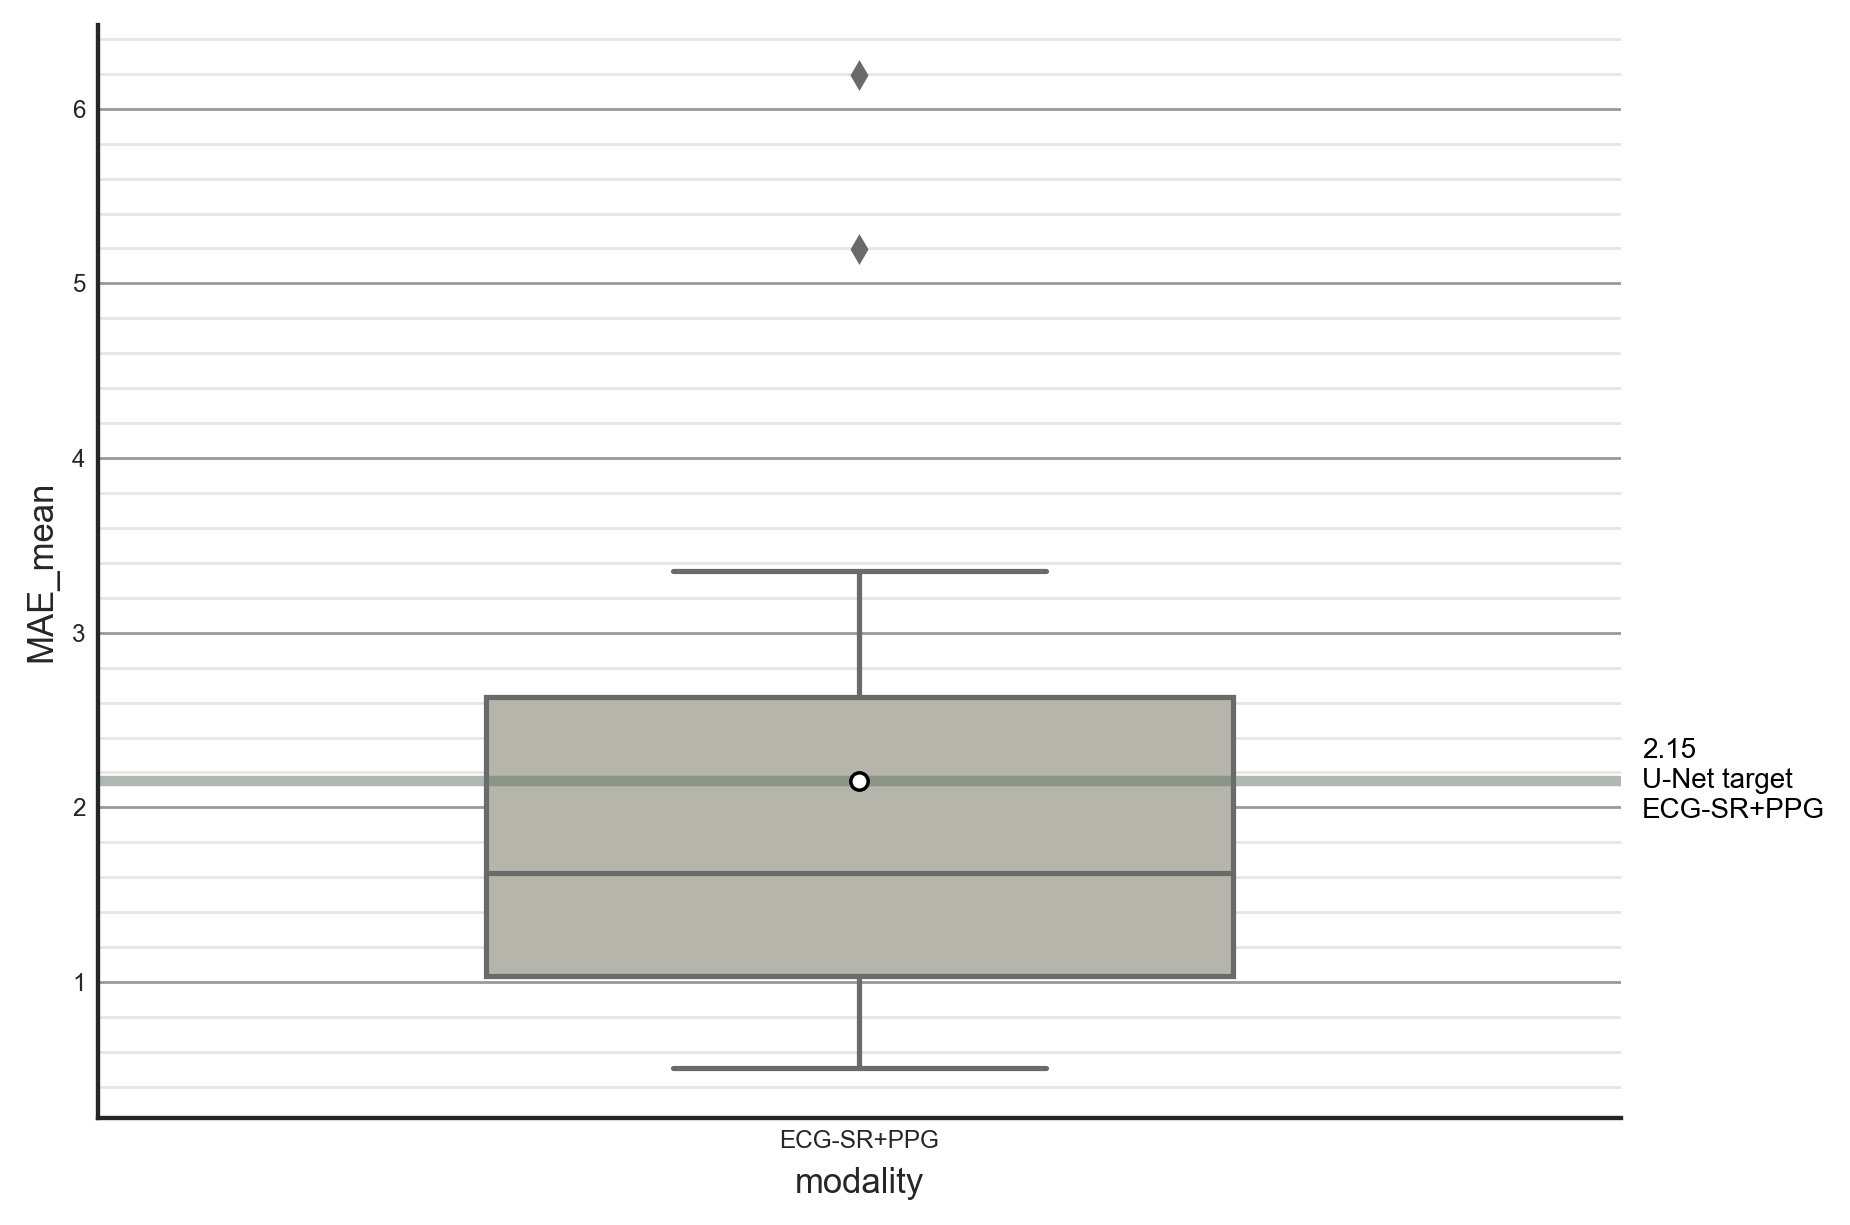

In [33]:
method_name1 = 'U-Net'

# modaliy_mask = df_performance_agg_joint['modality']=='ECGPPG'
# modality_mask = (df_performance_agg_joint['modality']!='SCGPPG') & (df_performance_agg_joint['modality']!='ECGSCG') & (df_performance_agg_joint['modality']!='ECGPPG') & (df_performance_agg_joint['modality']!='All')

mask =(df_performance_agg_joint['method']=='{}'.format(method_name1)) & (df_performance_agg_joint['TF_type']=='target')
df = df_performance_agg_joint[mask].copy()
df['hue_name'] = '{} target'.format(method_name1)




# method_name2 = 'U-Net-AT_block'
# # method_name2 = 'U-Net'

# # df4 = df_performance_agg_joint[(df_performance_agg_joint['method']=='{}'.format(method_name2))&(df_performance_agg_joint['TF_type']=='source')].copy()
# # df4['hue_name'] = '{} source'.format(method_name2)
# df2 = df_performance_agg_joint[(df_performance_agg_joint['method']=='{}'.format(method_name2))&(df_performance_agg_joint['TF_type']=='target')].copy()


# df2['hue_name'] = '{} target'.format(method_name2)


# # df3 = df_performance_agg_joint[(df_performance_agg_joint['method']=='U-Net RQI_fft') & (df_performance_agg_joint['TF_type']=='target')].copy()
# # df3['TF_type'] = 'U-Net RQI_fft'

# df = pd.concat([df1, df2])
# df = pd.concat([df1, df2, df3, df4, df5])
# plot_hue_compare(df, hue_order=['ST', '{} source'.format(method_name), '{} target'.format(method_name)], fig_name='Fig6Xmod_{}'.format(act_type), show_plot=True, outputdir=outputdir)
# hue_order=['ST', '{} source'.format(method_name1), '{} target'.format(method_name1), '{} source'.format(method_name2), '{} target'.format(method_name2)]
hue_order=['{} target'.format(method_name1)]
fig_name='Fig10Xmod_{}_modalities'.format(act_type)
plot_hue_compare(df, plt_scale=1.5, hue_order=hue_order, order_list=list_modalitites, fig_name=fig_name, show_plot=True, outputdir=outputdir)

In [34]:
aaa = df[df['modality']=='ppg-g-1']['MAE_mean'].values
bbb = df[df['modality']=='ppg-g-2']['MAE_mean'].values

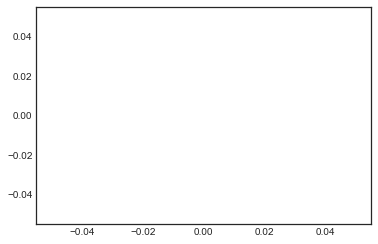

In [35]:
plt.plot(aaa)
plt.plot(bbb)
plt.show()

In [ ]:
# df

In [36]:
variable_name = 'modality'
df_table_agg = df[['MAE_mean', variable_name, 'subject_id']].copy()
df_table_agg = df_table_agg.groupby(variable_name)["MAE_mean"].agg([np.mean, np.std]).T
df_table_agg

modality,ECG-SR+PPG
mean,2.148744
std,1.566884


In [33]:
sys.exit()

SystemExit: 

/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
